# Topic Coherence in Practice

In this section, we will evaluate some topics using the `20newsgroups` dataset as a reference corpus to illustrate topic coherence in practice. We will first preprocess the data and then create some random topics. Finally, we will compute the coherence scores for these topics using Gensim's CoherenceModel.


In [2]:
%config InlineBackend.figure_format='retina'

import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

## Loading the Data

We first load and preprocess the `20newsgroups` dataset by removing headers, footers, and quotes, tokenizing the texts, and removing stopwords.


In [3]:
# Load the 20newsgroups dataset and preprocess the texts
texts, _ = fetch_20newsgroups(
    subset="all", remove=("headers", "footers", "quotes"), return_X_y=True
)
tokenizer = lambda s: re.findall("\w+", s.lower())
texts = [tokenizer(t) for t in texts]
stopwords = set(stopwords.words("english"))
texts = [[w for w in t if w not in stopwords and len(w) > 1] for t in texts]


Then, we find collocations in the texts and display the top 10 collocations.


In [4]:
# Find collocations in the texts
finder = BigramCollocationFinder.from_words(sum(texts[:100], []))
bgm = BigramAssocMeasures()
score = bgm.mi_like
collocations = {"_".join(bigram): pmi for bigram, pmi in finder.score_ngrams(score)}


In [5]:
# Top 10 collocations
collocations = pd.DataFrame(
    sorted(collocations.items(), key=lambda x: x[1], reverse=True),
    columns=["bigram", "score"],
)
collocations.head(10)


,bigram,score
0,united_states,7.111111
1,et_al,5.142857
2,greatly_appreciated,3.000000
3,hymenaeus_beta,3.000000
4,proving_existence,3.000000
5,3d_studio,2.666667
6,mozumder_proving,2.250000
7,_equinox_iii,2.000000
8,alex_delvecchio,2.000000
9,annals_cirp,2.000000


## Computing Coherence Scores

Next, we create some random topics and a dictionary with the vocabulary of the texts. We instantiate the CoherenceModel with the topics, texts, and dictionary, specifying the coherence measures. We compute the coherence scores for each topic and prepare the data for visualization.


In [6]:
# Create some random topics
topics = [
    ["car", "engine", "tire", "gasoline", "speed"],
    ["dog", "cat", "animal", "pet", "veterinarian"],
    ["movie", "director", "actor", "scene", "cinema"],
    ["music", "song", "artist", "instrument", "concert"],
]

# Create a dictionary with the vocabulary
word2id = Dictionary(texts)

# Instantiate the CoherenceModel
cm = CoherenceModel(topics=topics, texts=texts, coherence="c_v", dictionary=word2id)

# Compute coherence scores per topic
coherence_per_topic = cm.get_coherence_per_topic()

# Instantiate the CoherenceModel with c_uci coherence measure
cm_uci = CoherenceModel(
    topics=topics, texts=texts, coherence="c_uci", dictionary=word2id
)

# Compute coherence scores per topic
coherence_per_topic_uci = cm_uci.get_coherence_per_topic()

# Instantiate the CoherenceModel with u_mass coherence measure
cm_umass = CoherenceModel(
    topics=topics, texts=texts, coherence="u_mass", dictionary=word2id
)

# Compute coherence scores per topic
coherence_per_topic_umass = cm_umass.get_coherence_per_topic()

In [7]:
import numpy as np

# Combine all coherence scores into a single DataFrame
all_coherence_scores = pd.DataFrame(
    {
        "Topic": [", ".join(t) for t in topics] * 3,
        "Coherence": np.concatenate(
            [coherence_per_topic, coherence_per_topic_uci, coherence_per_topic_umass]
        ),
        "Measure": ["c_v"] * len(topics)
        + ["c_uci"] * len(topics)
        + ["u_mass"] * len(topics),
    }
)
all_coherence_scores

,Topic,Coherence,Measure
0,"car, engine, tire, gasoline, speed",0.702137,c_v
1,"dog, cat, animal, pet, veterinarian",0.326970,c_v
2,"movie, director, actor, scene, cinema",0.238576,c_v
3,"music, song, artist, instrument, concert",0.333913,c_v
4,"car, engine, tire, gasoline, speed",-0.406149,c_uci
5,"dog, cat, animal, pet, veterinarian",-3.889160,c_uci
6,"movie, director, actor, scene, cinema",-7.223855,c_uci
7,"music, song, artist, instrument, concert",-6.404229,c_uci
8,"car, engine, tire, gasoline, speed",-2.893048,u_mass
9,"dog, cat, animal, pet, veterinarian",-6.618890,u_mass


Here, we have the coherence scores for four different topics using three coherence measures: $c_{v}$, $c_{uci}$, and $u_{mass}$. Let's interpret the results:

1. Topic 1: "car, engine, tire, gasoline, speed"
   - $c_{v}$ coherence score: 0.702137
   - $c_{uci}$ coherence score: -0.406149
   - $u_{mass}$ coherence score: -2.893048

Topic 1 seems to be the most coherent topic according to the $c_{v}$ measure, while it has a relatively low negative score for the $c_{uci}$ and $u_{mass}$ measures. This suggests that this topic is quite coherent and has a strong relationship between the words, especially when considering the $c_{v}$ measure.

2. Topic 2: "dog, cat, animal, pet, veterinarian"
   - $c_{v}$ coherence score: 0.326970
   - $c_{uci}$ coherence score: -3.889160
   - $u_{mass}$ coherence score: -6.618890

Topic 2 has a lower $c_{v}$ coherence score than Topic 1, but it's still positive, indicating a reasonable level of coherence. However, the $c_{uci}$ and $u_{mass}$ measures show relatively large negative scores, suggesting a weaker relationship between the words in this topic.

3. Topic 3: "movie, director, actor, scene, cinema"
   - $c_{v}$ coherence score: 0.238576
   - $c_{uci}$ coherence score: -7.223855
   - $u_{mass}$ coherence score: -15.593594

Topic 3 has the lowest $c_{v}$ coherence score among the four topics, but it's still positive. However, it has the largest negative scores for both the $c_{uci}$ and $u_{mass}$ measures, which suggests that the relationship between the words in this topic is the weakest among the four topics.

4. Topic 4: "music, song, artist, instrument, concert"
   - $c_{v}$ coherence score: 0.333913
   - $c_{uci}$ coherence score: -6.404229
   - $u_{mass}$ coherence score: -9.202692

Topic 4 has a similar $c_{v}$ coherence score as Topic 2, indicating a decent level of coherence. The $c_{uci}$ and $u_{mass}$ measures show large negative scores, but they are not as low as Topic 3's scores.

In summary, according to the $c_{v}$ coherence measure, Topic 1 is the most coherent, followed by Topics 2, 4, and 3. However, the $c_{uci}$ and $u_{mass}$ measures give relatively large negative scores for all the topics, with Topic 3 consistently being the least coherent. It's important to note that the scale and interpretation of the coherence measures differ, so comparing the raw scores across measures can be misleading.


## Visualizing the Coherence Scores

Finally, we visualize the coherence scores.


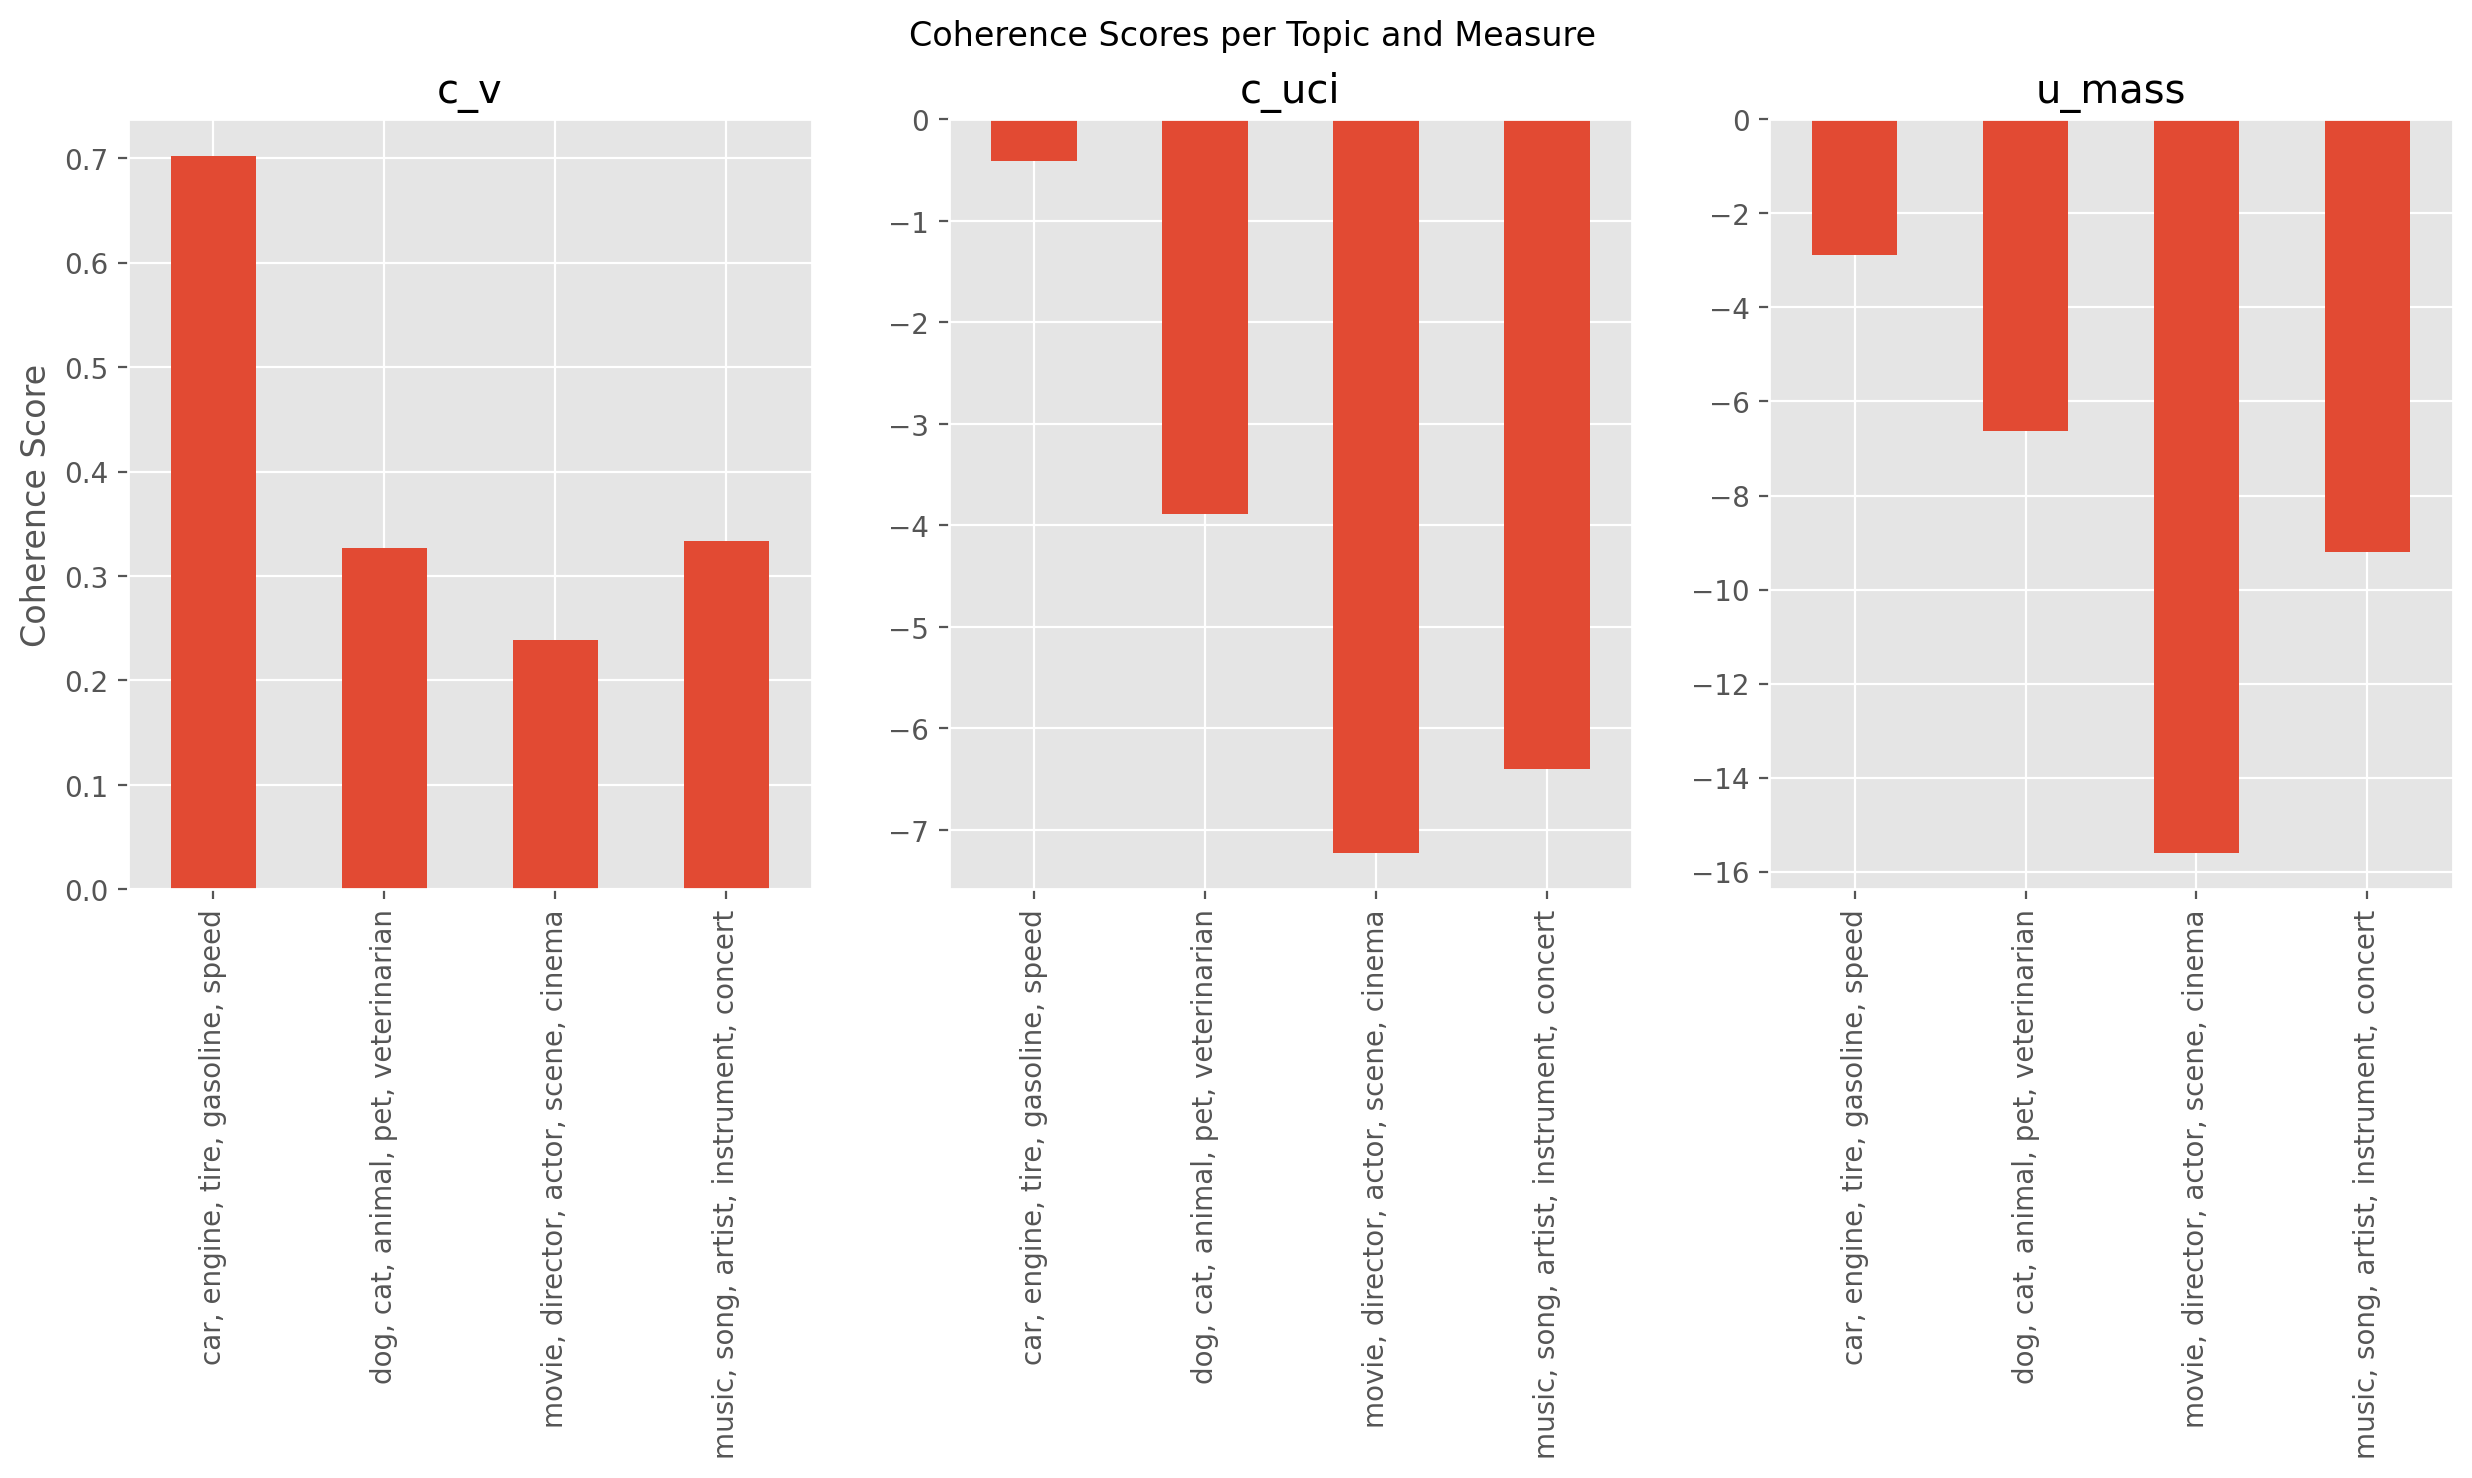

In [11]:
# Set plot style
plt.style.use("ggplot")

# Create a bar plot with subplots for each coherence measure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle("Coherence Scores per Topic and Measure")

for idx, measure in enumerate(["c_v", "c_uci", "u_mass"]):
    ax = axes[idx]
    data = all_coherence_scores[all_coherence_scores["Measure"] == measure]
    data.plot(kind="bar", x="Topic", y="Coherence", ax=ax, legend=False)
    ax.set_title(measure)
    ax.set_xlabel("")

# Add a y-label to the leftmost subplot
axes[0].set_ylabel("Coherence Score")

plt.show()

## Summary

By calculating topic coherence scores, we can gain insights into the quality of the topics generated by a topic model. Higher coherence scores indicate that the words in the topic are more related to each other, forming a coherent concept, while lower coherence scores suggest that the words in the topic may not be related or form a clear concept.
